In [1]:
from PIL import Image, ImageDraw, ImageOps, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import make_interp_spline
from matplotlib import colors
import os
import io

In [595]:
# source = Image.open('input/rainbow.png')
source = Image.open('input/frog.png')
# source = Image.open('input/moscow.jpg')
secret = Image.open('input/field.jpg')

In [596]:
source_ratio = source.size[0] / source.size[1]
secret_ratio = secret.size[0] / secret.size[1]

if secret_ratio > source_ratio:
    secret = secret.resize((int(source.size[1] * secret_ratio),
                           source.size[1]))
    crop_x = round(secret.size[0] / 2 - source.size[0] / 2)
    secret = secret.crop((crop_x, 
                          0, 
                          crop_x + source.size[0], 
                          secret.size[1]))
else:
    secret = secret.resize((source.size[0], 
                            int(source.size[0] / secret_ratio)))
    crop_y = round(secret.size[1] / 2 - source.size[1] / 2)
    secret = secret.crop((0,
                          crop_y, 
                          secret.size[0], 
                          crop_y + source.size[1]))

In [69]:
# (1080, 1080, 3)

In [74]:
source_np.shape

(1600, 2560, 3)

In [100]:
%%time

source_np = np.array(source)[:,:,:3]
secret_np = np.array(secret)[:,:,:3]

gs = np.array([0.2126, 0.7152, 0.0722])
gs = np.array([0.299, 0.587, 0.114])

for i in range(source_np.shape[0]):
    for j in range(source_np.shape[1]):
        # target = (secret_np[i][j] / 255) @ gs
        target = 0.5
        old_rgb = source_np[i][j] / 255
        delta = gs * (gs @ old_rgb - target) / (gs @ gs)
        new_rgb = old_rgb - delta
        new_rgb = np.clip(new_rgb, 0, 1)
        source_np[i][j] = new_rgb * 255

CPU times: user 17.5 s, sys: 145 ms, total: 17.7 s
Wall time: 18.3 s


In [202]:
source_np = np.array(source)[:,:,:3]
secret_np = np.array(secret)[:,:,:3]

h, w, *_ = source_np.shape

gs = np.array([0.2126, 0.7152, 0.0722])
# gs = np.array([0.299, 0.587, 0.114])

target = 0.5
# target = (secret_np / 255) @ gs

old_rgb = source_np / 255
delta = gs * np.expand_dims(old_rgb @ gs - target, -1) / (gs @ gs)
new_rgb = old_rgb - delta
new_rgb = np.clip(new_rgb, 0, 1) * 255
source_np = new_rgb.astype('uint8')

In [207]:
a = np.random.uniform(size=(3, 1)).T
b = np.random.uniform(size=(3, 1))
(a @ b).shape

(1, 1)

In [459]:
%%time

# gs = [0.2126, 0.7152, 0.0722]
gs = [0.299, 0.587, 0.114]

source_np = np.array(source)[..., :3] / 255
secret_np = np.array(secret)[..., :3] / 255

h, w, _ = source_np.shape

gs = np.reshape(gs, (1, 3))

t = 0.2
# t = secret_np.reshape((h, w, 1, 3)) @ gs.T

colors = source_np.reshape((h, w, 1, 3))
bcs = -gs * (colors @ gs.T - t) / (gs @ gs.T)

ks = np.zeros((h, w, 6, 3))
ks[...] = (np.eye(6, k=-1) + np.eye(6))[..., ::2]

_tmp = np.reshape([0, 1] * 3, (3, 2))
alphas = _tmp - np.moveaxis(colors, -1, -2)
alphas = alphas.reshape((h, w, 6, 1))

matrix = np.zeros((3, 3))
matrix[0, 0] = gs[0, 1] ** 2 + gs[0, 2] ** 2
matrix[1, 1] = gs[0, 0] ** 2 + gs[0, 2] ** 2
matrix[2, 2] = gs[0, 0] ** 2 + gs[0, 1] ** 2
matrix[0, 1] = matrix[1, 0] = -gs[0, 0] * gs[0, 1]
matrix[0, 2] = matrix[2, 0] = -gs[0, 0] * gs[0, 2]
matrix[1, 2] = matrix[2, 1] = -gs[0, 1] * gs[0, 2]

ms = ks @ matrix

ks = ks.reshape((h, w, 6, 1, 3))
ms = ms.reshape((h, w, 6, 3, 1))
bcs = bcs.reshape((h, w, 1, 3, 1))
alphas = alphas.reshape((h, w, 6, 1, 1))

bbcs = ms * (alphas - ks @ bcs) / (ks @ ms) + bcs
bbcs = bbcs.reshape((h, w, 6, 3))

# print(bbcs[i, j]); print()

_c = np.round((colors.repeat(6, axis=2) + bbcs) * 255)
bbcs = np.where((_c < 0) | (_c > 255), 2, bbcs)

# print(bbcs[i, j]); print()

# bbcs = np.nan_to_num(bbcs, nan=2)

# _ds = np.sum((bbcs - bcs.reshape((h, w, 1, 3))) ** 2, axis=-1)
_ds = np.sum(bbcs ** 2, axis=-1)
_min_ds = np.min(_ds, axis=-1)[..., None]
bbcs = (_min_ds == _ds)[..., None] * bbcs
bbcs = bbcs.sum(axis=-2)

# print(bbcs[i, j]); print()

colors = colors.reshape((h, w, 3))
bcs = bcs.reshape((h, w, 3))

nc1 = np.round((colors + bcs) * 255)
nc2 = np.round((colors + bbcs) * 255)

# print(np.min(nc1), np.max(nc1))
# print(np.min(nc2), np.max(nc2))

# print(nc1[i, j]); print()


nc = np.full_like(colors, t * 255)
_nc1_cond = np.any(nc1 < 0, axis=-1) | np.any(nc1 > 255, axis=-1)
_nc2_cond = np.any(nc2 < 0, axis=-1) | np.any(nc2 > 255, axis=-1)
nc[~_nc1_cond] = nc1[~_nc1_cond]
nc[~_nc2_cond] = nc2[~_nc2_cond]

# _l_lim = np.any(nc1 < 0, axis=-1)
# _r_lim = np.any(nc1 > 255, axis=-1)
# _condition = (_l_lim | _r_lim)[..., None].repeat(3, -1)
# nc = np.where(_condition, nc2, nc1)#.astype('uint8')

# Image.fromarray((np.clip(color + bc, 0, 1) * 255).reshape((h, w, 3)).astype('uint8')).convert('L')

CPU times: user 2.4 s, sys: 978 ms, total: 3.37 s
Wall time: 5.07 s


In [441]:
(nc1 < 255).shape

(1080, 1080, 3)

In [378]:
i, j = [165, 390]

gs = gs.reshape(3)

color = colors[i, j].flatten()
k = ks[i, j].reshape(6, 3)
# m = ms[i, j].reshape(6, 3, 1)
alpha = alphas[i, j].reshape(6)
bc = bcs[i, j].reshape(3)

print(bc)

for i, sign in list(enumerate([1, -1] * 3))[:-1]:
    mask = k[i].astype(bool)
    if sign * bc[mask] < alpha[i]:
        print(i, k[i].astype(int), alpha[i])
        bc_rest = bc[~mask]
        gs_rest = gs[~mask]
        coeff = (t - gs_rest @ bc_rest) / (gs_rest @ gs_rest)
        bc[mask] = alpha[i]
        bc[~mask] = gs_rest * coeff

bc

[-0.42535549 -0.83506246 -0.16217567]
4 [0 0 1] -0.11764705882352941


array([ 0.49425426,  0.97032526, -0.11764706])

In [438]:
_1 = np.any(nc1 < 0, axis=-1)
_2 = np.any(nc1 > 255, axis=-1)
_3 = np.any(nc2 < 0, axis=-1)
_4 = np.any(nc2 > 255, axis=-1)
((_1 | _2) & (_3 | _4)).shape

(1080, 1080)

In [433]:
nc[i, j]

array([87.,  1.,  0.])

In [434]:
nc1[i, j]

array([ 88.,   1., -11.])

In [435]:
nc2[i, j]

array([ 87., 724.,   0.])

In [437]:
_nc1_cond.shape

(1080, 1080, 3)

In [398]:
for rgb in nc[((_1 | _2) & (_3 | _4))]

array([[0.76862745, 0.83921569, 0.11764706],
       [0.72941176, 0.75686275, 0.10588235],
       [0.72941176, 0.76078431, 0.09019608],
       ...,
       [0.54509804, 0.34901961, 0.        ],
       [0.57647059, 0.38431373, 0.        ],
       [0.61568627, 0.42745098, 0.02745098]])

In [314]:
for i in range(h):
    for j in range(w):
        val = round((nc[i, j] / 255) @ gs.flatten(), 2)
        if val != t:
            print(f'[{i:>3}, {j:>3}]; val = {val}')

[165, 390]; val = 0.59
[166, 363]; val = 0.54
[166, 364]; val = 0.54
[166, 365]; val = 0.54
[166, 366]; val = 0.55
[166, 367]; val = 0.55
[166, 762]; val = 0.56
[167, 377]; val = 0.55
[167, 762]; val = 0.57
[168, 377]; val = 0.53
[168, 762]; val = 0.54
[169, 378]; val = 0.53
[169, 379]; val = 0.52
[169, 381]; val = 0.54
[169, 762]; val = 0.53
[170, 381]; val = 0.57
[170, 382]; val = 0.57
[170, 383]; val = 0.56
[170, 760]; val = 0.59
[171, 759]; val = 0.58
[171, 760]; val = 0.57
[172, 759]; val = 0.58
[175, 757]; val = 0.59
[175, 759]; val = 0.57
[175, 761]; val = 0.53
[176, 758]; val = 0.56
[176, 759]; val = 0.56
[177, 343]; val = 0.29
[177, 344]; val = 0.26
[177, 391]; val = 0.57
[177, 756]; val = 0.6
[186, 761]; val = 0.23
[187, 760]; val = 0.21
[188, 759]; val = 0.24
[188, 760]; val = 0.24
[190, 758]; val = 0.22
[191, 757]; val = 0.23
[191, 758]; val = 0.22
[196, 722]; val = 0.6
[196, 723]; val = 0.62
[197, 726]; val = 0.65
[198, 726]; val = 0.65
[199, 726]; val = 0.64
[200, 724]; v

In [406]:
for rgb in nc[((_1 | _2) & (_3 | _4))]:
    rgb[0] = 255
    rgb[1] = 255
    rgb[2] = 255

In [408]:
nc[((_1 | _2) & (_3 | _4))] = np.array([255, 255, 255])

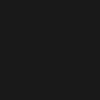

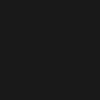

In [428]:
display(Image.fromarray(np.full((100, 100, 3), t * 255).astype('uint8')))
display(Image.fromarray(np.full((100, 100, 3), t * 255).astype('uint8')).convert('L'))

In [444]:
nc[165, 390]

array([25.5, 25.5, 25.5])

In [472]:
print(colors[512, 453])
print(colors[512, 455])

[0.34117647 1.         0.        ]
[0.32941176 1.         0.        ]


In [545]:
def get_vertices(gs):
    # vertices = np.arange(256)[..., None, None]\
    #          .repeat(3, axis=-1)\
    #          .repeat(12, axis=-2) / 255
    vertices = np.zeros((256, 12, 3))

    # lines = np.zeros((256, 3, 3))
    gs = np.array(gs).flatten()

    for t in range(256):
        # find vertices
        index = 0
        # vertices_inside = []
        for i, j in ((0, 1), (1, 2), (0, 2)):
            for i_limit in (0, 1):
                for j_limit in (0, 1):
                    A = np.array([[*gs], 
                                  [*np.eye(3)[i]], 
                                  [*np.eye(3)[j]]])
                    b = np.array([t / 255, i_limit, j_limit])
                    vertex = np.linalg.solve(A, b)
                    
                    # if np.all(dot >= 0) & np.all(dot <= 1):
                    #     vertices[t, index] = dot
                    #     vertices_inside.append(dot)
                    vertices[t, index] = vertex
                    
                    index += 1
        # vertices_inside = np.array(vertices_inside)
        
        # find lines
        # index = 0
        # for i in range(len(vertices_inside)):
        #     for j in range(i + 1, len(vertices_inside)):
        #         if np.any(vertices_inside[i] == vertices_inside[j]):
        #             lines[t, index] = vertices_inside[i] - vertices_inside[j]
        #             index += 1

        # for i, k in enumerate(np.eye(3)):
        #     for i_limit in (0, 1):
        #         m = np.cross(gs, np.cross(gs, k))
                
                
        #         lines[t, i] = np.cross(np.array(gs), n)
        #         index += 1
    
    return vertices#, lines

In [664]:
%%time

gs = [0.2126, 0.7152, 0.0722]
# gs = [0.299, 0.587, 0.114]

source_np = np.array(source)[..., :3] / 255
secret_np = np.array(secret)[..., :3] / 255

h, w, _ = source_np.shape

gs = np.reshape(gs, (1, 3))

t = 0.1
# t = secret_np.reshape((h, w, 1, 3)) @ gs.T

t_index = np.round(t * 255).astype(int)

colors = source_np.reshape((h, w, 1, 3))

# ci = (h, w, 1, 3)
ci = gs * (t - colors @ gs.T) / (gs @ gs.T) + colors

# vertices = (12, 3)
vertices = get_vertices(gs)[t_index]

# КОСТЫЛЬ ВРЕМЕННЫЙ!!!!!!!!!!!!!!!!!!!!!
vertices = vertices[None, None, ...].repeat(h, axis=0).repeat(w, axis=1)

# ks = (6, 3)
ks = (np.eye(6, k=-1) + np.eye(6))[..., ::2]

# alphas = (6, 1)
alphas = np.reshape([0, 1] * 3, (6, 1))

# ms = (6, 3)
ms = np.cross(gs.flatten(), np.cross(gs.flatten(), ks))

# modas = (h, w, 6, 3)
_ksms = (ks[..., None, :] @ ms[..., None]).reshape(6, 1)
modas = ms * (alphas - ks @ ci.reshape((h, w, 3, 1))) / _ksms + ci

# options = (h, w, 19, 3)
options = np.concatenate([ci, vertices, modas], axis=-2)

mask = np.any(options < 0, axis=-1) | np.any(options > 1, axis=-1)
options[mask] = np.array([3, 3, 3])

_ds = np.sum((options - ci) ** 2, axis=-1)
best_indices = (np.arange(h)[:, None, None], 
                np.arange(w)[None, :, None], 
                np.argmin(_ds, axis=-1)[..., None], 
                np.arange(3))
nc = options[best_indices]

#==================================================================================
#==================================================================================
#==================================================================================

# _ds = np.sum((bbcs - bcs.reshape((h, w, 1, 3))) ** 2, axis=-1)
# _ds = np.sum(bbcs ** 2, axis=-1)
# _min_ds = np.min(_ds, axis=-1)[..., None]
# bbcs = (_min_ds == _ds)[..., None] * bbcs
# bbcs = bbcs.sum(axis=-2)


CPU times: user 2.94 s, sys: 1.45 s, total: 4.39 s
Wall time: 5.46 s


In [647]:
import numpy as np

# Создаем массивы A и B
A = np.random.rand(100, 200, 19, 3)
B = np.random.randint(0, 19, size=(100, 200))

# Подготавливаем индексы для выборки из массива A
indices = np.arange(100)[:, None, None], np.arange(200)[None, :, None], B[..., None], np.arange(3)

# Используем индексы для выборки из массива A
result = A[indices]

# Приводим к нужной форме
result = result[:, :, None, :]

print(result.shape)  # должно быть (100, 200, 1, 3)


(100, 200, 1, 3)


In [652]:
np.argmin(_ds, axis=-1).shape

(1080, 1080)

In [655]:
options[indices].shape

(1080, 1080, 3)

In [653]:
indices = (np.arange(h)[:, None, None], 
           np.arange(w)[None, :, None], 
           np.argmin(_ds, axis=-1)[..., None], 
           np.arange(3))
options[indices]

array([[[0.15632496, 0.25444949, 0.0341841 ],
        [0.15632496, 0.25444949, 0.0341841 ],
        [0.15632496, 0.25444949, 0.0341841 ],
        ...,
        [0.15862233, 0.25140512, 0.04383436],
        [0.15862233, 0.25140512, 0.04383436],
        [0.15862233, 0.25140512, 0.04383436]],

       [[0.15632496, 0.25444949, 0.0341841 ],
        [0.15632496, 0.25444949, 0.0341841 ],
        [0.15632496, 0.25444949, 0.0341841 ],
        ...,
        [0.15862233, 0.25140512, 0.04383436],
        [0.15862233, 0.25140512, 0.04383436],
        [0.15862233, 0.25140512, 0.04383436]],

       [[0.15632496, 0.25444949, 0.0341841 ],
        [0.15632496, 0.25444949, 0.0341841 ],
        [0.15632496, 0.25444949, 0.0341841 ],
        ...,
        [0.15862233, 0.25140512, 0.04383436],
        [0.15862233, 0.25140512, 0.04383436],
        [0.15862233, 0.25140512, 0.04383436]],

       ...,

       [[0.16961839, 0.24205298, 0.06314915],
        [0.16702196, 0.24451022, 0.05730642],
        [0.16442553, 0

In [620]:
a = np.random.uniform(size=(2, 3, 4))
b = np.argmin(a, axis=-1)

In [627]:
a

array([[[0.74989126, 0.12514311, 0.21568732, 0.26668795],
        [0.25657826, 0.92506552, 0.83668109, 0.45232747],
        [0.2299485 , 0.86329572, 0.15087907, 0.77461614]],

       [[0.05404758, 0.59164476, 0.7280845 , 0.77006954],
        [0.7256615 , 0.74373236, 0.36176582, 0.3743732 ],
        [0.42716752, 0.55502332, 0.5621823 , 0.80203411]]])

In [645]:
# Пример массивов A и B
A = np.random.rand(2, 3, 4, 3)  # Создаем массив A с случайными значениями
B = np.random.randint(0, 4, (2, 3))  # Создаем массив B с случайными индексами от 0 до 2 для второй размерности

# Используем индексацию для выбора нужных элементов
# result = A[np.arange(A.shape[0])[:, None], B, np.arange(A.shape[2])]
result = A[np.arange(A.shape[0]), np.arange(A.shape[1])[:, None], B]

print("Массив A:")
print(A)
print("\nМассив B:")
print(B)
print("\nРезультирующий массив:")
print(result)


IndexError: index 3 is out of bounds for axis 0 with size 2

In [626]:
np.minimum.reduce(a, axis=1)

array([[0.2299485 , 0.12514311, 0.15087907, 0.26668795],
       [0.05404758, 0.55502332, 0.36176582, 0.3743732 ]])

In [614]:
np.argmin(_ds, axis=-1).shape

(1080, 1080)

In [604]:
np.round(options[165, 390][np.any(options[165, 390] < 2, axis=-1)], 3)

array([[0.669, 0.   , 0.   ],
       [0.288, 0.   , 1.   ],
       [0.   , 0.341, 0.   ],
       [0.   , 0.147, 1.   ],
       [0.   , 0.337, 0.02 ],
       [0.642, 0.   , 0.07 ]])

In [534]:
%%time
dots, lines = get_dots(gs.flatten())

CPU times: user 158 ms, sys: 20.9 ms, total: 178 ms
Wall time: 228 ms


In [538]:
lines[51]

array([[ 0.   ,  0.114, -0.587],
       [-0.114,  0.   ,  0.299],
       [ 0.587, -0.299,  0.   ]])

In [471]:
for i in range(450, 513, 1):
    print(f'[512, {i:>3}] ->', nc[512, i])

[512, 450] -> [ 5. 84.  0.]
[512, 451] -> [ 3. 85.  0.]
[512, 452] -> [ 3. 86.  0.]
[512, 453] -> [ 1. 86.  0.]
[512, 454] -> [ 0. 87.  0.]
[512, 455] -> [160.   0.  29.]
[512, 456] -> [159.   0.  29.]
[512, 457] -> [159.   0.  30.]
[512, 458] -> [159.   0.  30.]
[512, 459] -> [159.   0.  31.]
[512, 460] -> [159.   0.  31.]
[512, 461] -> [158.   0.  32.]
[512, 462] -> [158.   0.  32.]
[512, 463] -> [158.   0.  33.]
[512, 464] -> [158.   0.  33.]
[512, 465] -> [158.   0.  34.]
[512, 466] -> [158.   0.  34.]
[512, 467] -> [157.   0.  35.]
[512, 468] -> [157.   0.  35.]
[512, 469] -> [157.   0.  36.]
[512, 470] -> [157.   0.  36.]
[512, 471] -> [157.   0.  37.]
[512, 472] -> [156.   0.  37.]
[512, 473] -> [156.   0.  38.]
[512, 474] -> [156.   0.  38.]
[512, 475] -> [156.   0.  39.]
[512, 476] -> [156.   0.  39.]
[512, 477] -> [155.   0.  40.]
[512, 478] -> [155.   0.  40.]
[512, 479] -> [155.   0.  41.]
[512, 480] -> [155.   0.  41.]
[512, 481] -> [155.   0.  42.]
[512, 482] -> [155.   0

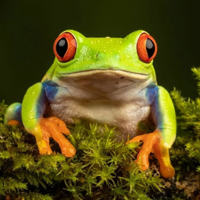

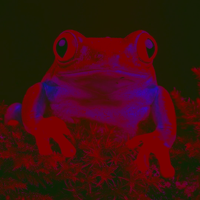

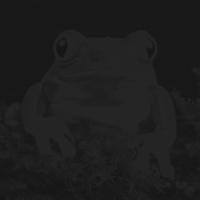

In [665]:
display(source.resize((200, 200)))
display(Image.fromarray(np.round(nc * 255).astype('uint8')).resize((200, 200)))
display(Image.fromarray(np.round(nc * 255).astype('uint8')).convert('L').resize((200, 200)))

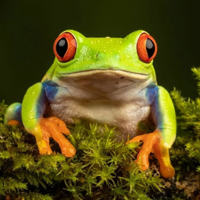

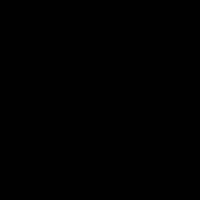

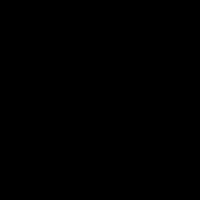

In [657]:
display(source.resize((200, 200)))
display(Image.fromarray(np.clip(nc, 0, 255).astype('uint8')).resize((200, 200)))
display(Image.fromarray(np.clip(nc, 0, 255).astype('uint8')).convert('L').resize((200, 200)))

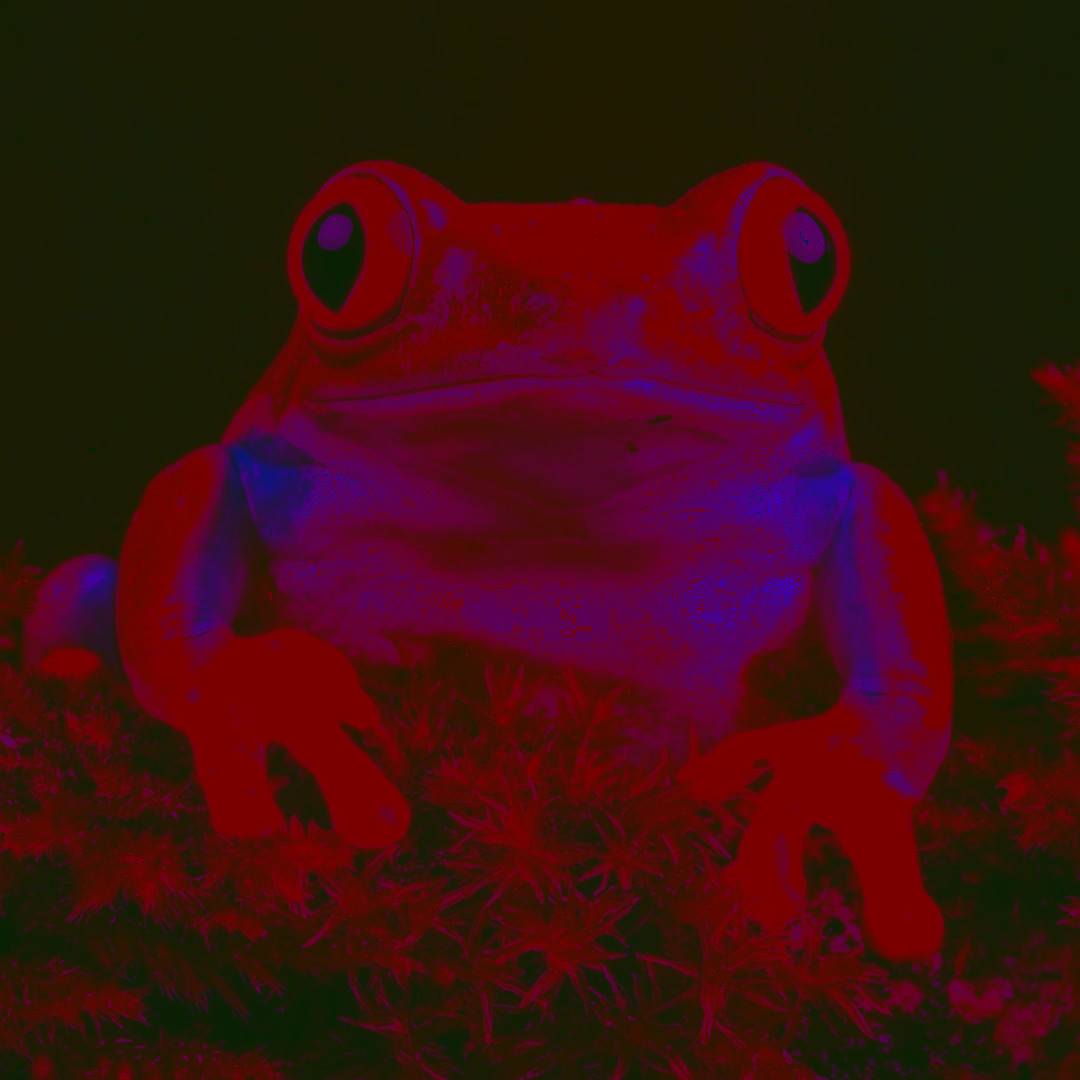

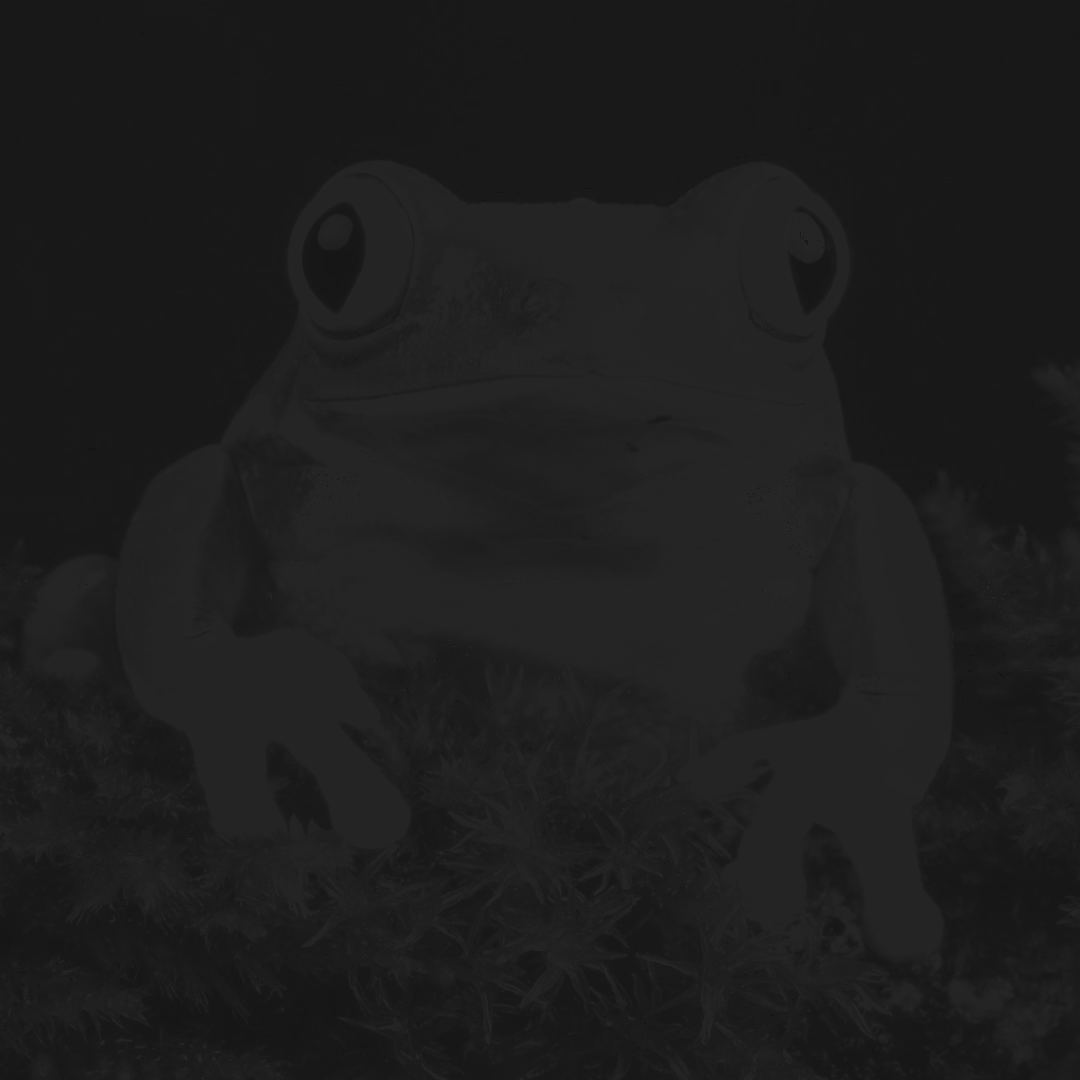

In [666]:
display(Image.fromarray(np.round(nc * 255).astype('uint8')))
display(Image.fromarray(np.round(nc * 255).astype('uint8')).convert('L'))

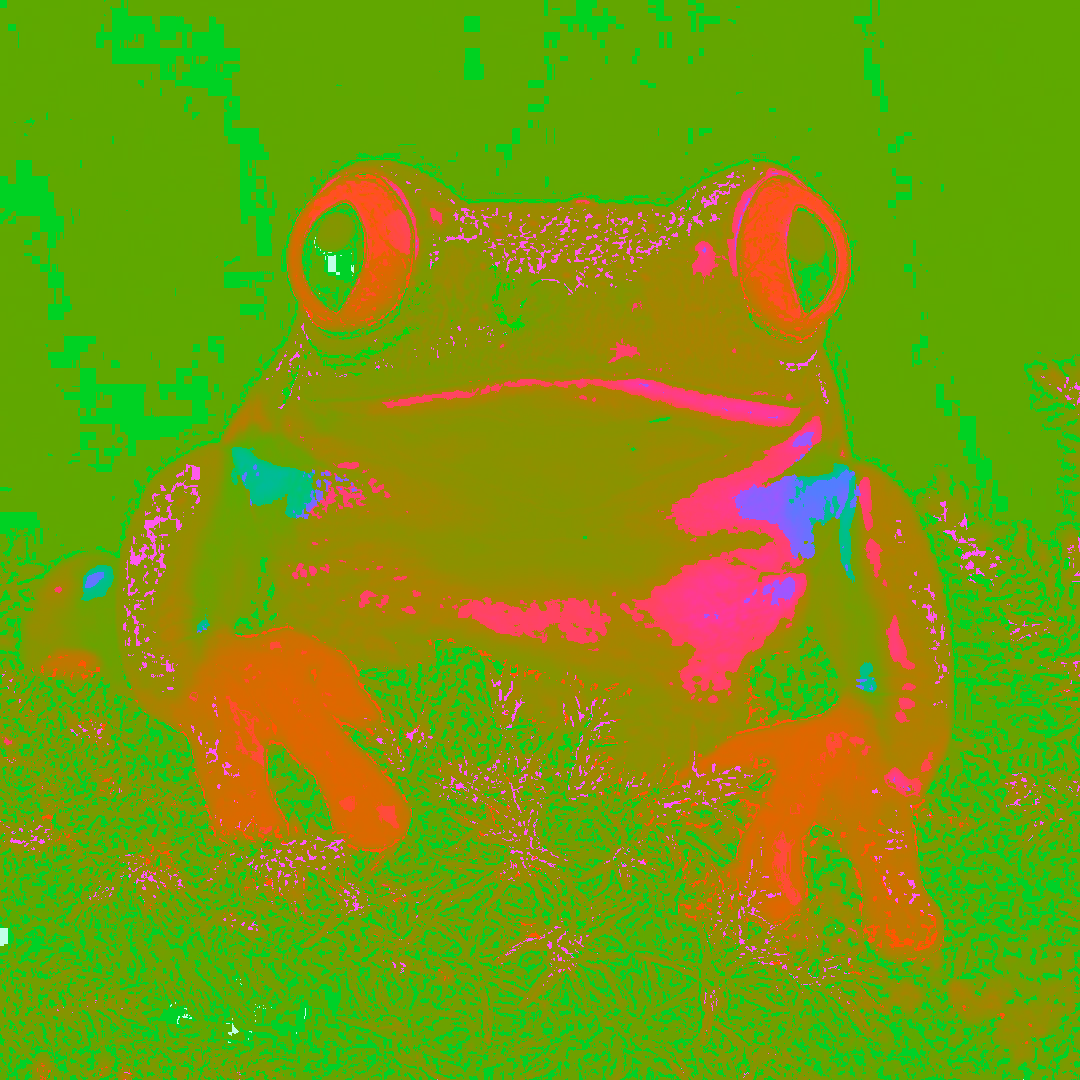

In [255]:
Image.fromarray(((colors + bbcs) * 255).astype('uint8'))#.convert('L')

In [374]:
print('    ms:', ms.shape)
print('alphas:', alphas.shape)
print('    ks:', ks.shape)
print('   bcs:', bcs.shape)

    ms: (1080, 1080, 6, 3, 1)
alphas: (1080, 1080, 6, 1, 1)
    ks: (1080, 1080, 6, 1, 3)
   bcs: (1080, 1080, 1, 3, 1)


In [386]:

i, j = [165, 390]
color = colors[i, j].flatten()

# Исходные данные
P = colors[i, j].flatten()
A, B, C, D = *gs.flatten(), -0.7
x_min, x_max = 0, 1
y_min, y_max = 0, 1
z_min, z_max = 0, 1

# Проекция точки на плоскость
t = -(A*P[0] + B*P[1] + C*P[2] + D) / (A**2 + B**2 + C**2)
P_proj = P + t * np.array([A, B, C])

# Проверка принадлежности проекции параллелепипеду
if (x_min <= P_proj[0] <= x_max and y_min <= P_proj[1] <= y_max and z_min <= P_proj[2] <= z_max):
    closest_point = P_proj
    print('ideal')
else:
    # Проверка пересечения плоскости с гранями параллелепипеда
    # Эта часть может быть реализована аналогично вышеописанному методу
    
    # Находим все точки пересечения и выбираем ближайшую
    # Примерный алгоритм:
    candidates = []
    for x in [x_min, x_max]:
        for y in [y_min, y_max]:
            z = (-A*x - B*y - D) / C
            if z_min <= z <= z_max:
                candidates.append([x, y, z])
    
    for y in [y_min, y_max]:
        for z in [z_min, z_max]:
            x = (-B*y - C*z - D) / A
            if x_min <= x <= x_max:
                candidates.append([x, y, z])
    
    for x in [x_min, x_max]:
        for z in [z_min, z_max]:
            y = (-A*x - C*z - D) / B
            if y_min <= y <= y_max:
                candidates.append([x, y, z])
    
    # Находим ближайшую точку
    distances = [np.linalg.norm(np.array(c) - P) for c in candidates]
    closest_point = candidates[np.argmin(distances)]

print("Ближайшая точка на плоскости внутри параллелепипеда:")
closest_point

ideal
Ближайшая точка на плоскости внутри параллелепипеда:


array([0.74464477, 0.79213263, 0.10850316])

In [322]:
i, j = [165, 390]

color = colors[i, j].flatten()
k = ks[i, j].reshape(6, 1, 3)
m = ms[i, j].reshape(6, 3, 1)
alpha = alphas[i, j].reshape(6, 1, 1)
bc = bcs[i, j].reshape(3, 1)

dots = (m * (alpha - k @ bc) / (k @ m) + bc).reshape(6, 3)

print('color:', color), print()
print('matrix:\n', matrix, '\n', sep='')
print('k:\n', k.reshape(6, 3), '\n', sep='')
print('m:\n', m.reshape(6, 3), '\n', sep='')
print('alpha:\n', alpha.reshape(6), '\n', sep='')
print('bc:\n', bc.reshape(3), '\n', sep='')
print('dots:\n', dots, '\n', sep='')
# (color + bc) @ gs.flatten()

color: [0.76862745 0.83921569 0.11764706]

matrix:
[[ 0.357565 -0.175513 -0.034086]
 [-0.175513  0.102397 -0.066918]
 [-0.034086 -0.066918  0.43397 ]]

k:
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]

m:
[[ 0.357565 -0.175513 -0.034086]
 [ 0.357565 -0.175513 -0.034086]
 [-0.175513  0.102397 -0.066918]
 [-0.175513  0.102397 -0.066918]
 [-0.034086 -0.066918  0.43397 ]
 [-0.034086 -0.066918  0.43397 ]]

alpha:
[-0.76862745  0.23137255 -0.83921569  0.16078431 -0.11764706  0.88235294]

bc:
[-0.42535549 -0.83506246 -0.16217567]

dots:
[[-0.76862745 -0.66656528 -0.1294522 ]
 [ 0.23137255 -1.15742149 -0.22478032]
 [-0.41823667 -0.83921569 -0.15946147]
 [-2.13228103  0.16078431 -0.81297671]
 [-0.42885297 -0.84192875 -0.11764706]
 [-0.50739757 -0.99612835  0.88235294]]



In [124]:
def get_borders(color):
    r, g, b = color
    return np.array(
        [[ -r,   0,   0], 
         [1-r,   0,   0],
         [  0,  -g,   0],
         [  0, 1-g,   0],
         [  0,   0,  -b],
         [  0,   0, 1-b]]
    )

def get_matrix(grayscale):
    r, g, b = grayscale
    return np.array(
        [[g*g+b*b,    -r*g,    -r*b], 
         [   -r*g, r*r+b*b,    -g*b], 
         [   -r*b,    -g*b, r*r+g*g]]
    )

# color = np.array([0.1, 0.9, 0.1])
# gs = np.array([0.2, 0.3, 0.5])
color = np.array([0.06666667, 0.07843137, 0.0])
gs = np.array([0.299, 0.587, 0.114])
target = 0.5

borders = get_borders(color)
alphas = np.sum(borders, axis=-1)
ks = borders.astype(bool).astype(int)
matrix = get_matrix(gs)
ms = borders @ matrix
bc = -gs * (gs @ color - target) / (gs @ gs)
dots = ms * np.expand_dims(alphas - ks @ bc, -1) / (np.expand_dims(ks, -2) @ np.expand_dims(ms, -1)).reshape((6, 1)) + bc

print('color:', color), print()
print('matrix:\n', matrix, '\n', sep='')
print('k:\n', ks, '\n', sep='')
print('m:\n', ms, '\n', sep='')
print('alpha:\n', alphas, '\n', sep='')
print('bc:\n', bc, '\n', sep='')
print('dots:\n', dots, '\n', sep='')

color: [0.06666667 0.07843137 0.        ]

matrix:
[[ 0.357565 -0.175513 -0.034086]
 [-0.175513  0.102397 -0.066918]
 [-0.034086 -0.066918  0.43397 ]]

k:
[[1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 0 0]
 [0 0 1]]

m:
[[-0.02383767  0.01170087  0.0022724 ]
 [ 0.33372733 -0.16381213 -0.0318136 ]
 [ 0.01376573 -0.00803114  0.00524847]
 [-0.16174727  0.09436586 -0.06166953]
 [ 0.          0.          0.        ]
 [-0.034086   -0.066918    0.43397   ]]

alpha:
[-0.06666667  0.93333333 -0.07843137  0.92156863  0.          1.        ]

bc:
[0.2903447  0.57000782 0.11069998]

dots:
[[-0.06666667  0.74524906  0.14473321]
 [ 0.93333333  0.25439286  0.04940509]
 [ 1.40179823 -0.07843137  0.53446488]
 [-0.31224613  0.92156863 -0.11905036]
 [        nan         nan         nan]
 [ 0.22049498  0.43287811  1.        ]]



/var/folders/5d/m60s_l4s0rxgzhtn791xykqr0000gn/T/ipykernel_58315/3865206412.py:32: RuntimeWarning: invalid value encountered in divide
  dots = ms * np.expand_dims(alphas - ks @ bc, -1) / (np.expand_dims(ks, -2) @ np.expand_dims(ms, -1)).reshape((6, 1)) + bc


In [197]:
np.sum(dots ** 2, axis=-1)

array([0.43470588, 0.90529412, 2.17862069, 0.38551724, 1.30307692,
       0.87230769])

In [155]:
r, g, b = 0.2, 0.3, 0.5
np.dot([0, 0.1, 0], [[g*g+b*b, -r*g, -r*b], [-r*g, r*r+b*b, -g*b], [-r*b, -g*b, r*r+g*g]])

array([-0.006,  0.029, -0.015])